# 감성분석 예제  2: 영화 감상평  예제


### 5개의 Label : 5단계 분석
- 0 : '부정적'
- 1 : '약간 부정적'
- 2 : '중립적'
- 3 : '약간 긍정적'
- 4 : '긍정적'

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
# import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re

from tqdm import tqdm

In [4]:
from tensorflow.keras.utils import to_categorical
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Bidirectional


tf.random.set_seed(123)

random.seed(123)

## 데이터 가져오기

In [5]:
train= pd.read_csv("/content/drive/My Drive/NLP_LAB/train.tsv", sep="\t")  # tsv: tab seperated value

train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
train.shape

(156060, 4)

### 텍스트 전처리

In [7]:

def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        # remove html content
        # review_text = BeautifulSoup(sent).get_text() 
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", sent)  # 영문자이외에는 공백으로 변경
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower()) 
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]  # 표제어
    
        reviews.append(lemma_words)

    return(reviews)



In [8]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# 전처리 코드 실행
train_sentences = clean_sentences(train)
# test_sentences = clean_sentences(test)
print(len(train_sentences))
# print(len(test_sentences))

100%|██████████| 156060/156060 [00:26<00:00, 6001.57it/s]

156060


In [10]:
# train_sentences[0]

In [11]:
target=train.Sentiment.values   # raw Y
print(target,target.shape)       # (156060,)
y_target = to_categorical(target)  # one-hot 벡터로 변환
print(y_target,y_target.shape)   # target Y: (156060, 5)
num_classes=y_target.shape[1]
print('num_classes:',num_classes)

[1 2 2 ... 3 2 2] (156060,)
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]] (156060, 5)
num_classes: 5


2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64


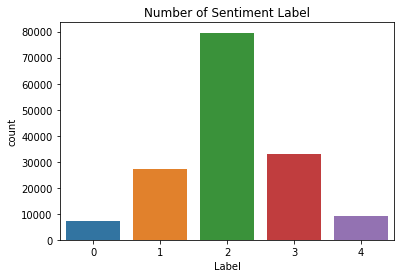

In [12]:
# Y 레이블의 분포
print(train['Sentiment'].value_counts())
sns.countplot(train['Sentiment'])
plt.xlabel('Label')
plt.title('Number of Sentiment Label')
plt.show()

#

In [13]:
# stratify=y_target: y값의 분포를 원본과 동일한 비율로 split시킴
X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [14]:
X_train

[['be',
  'the',
  'biggest',
  'husband',
  'and',
  'wife',
  'disaster',
  'since',
  'john'],
 ['old',
  'people',
  'will',
  'love',
  'this',
  'movie',
  'and',
  'i',
  'mean',
  'that',
  'in',
  'the',
  'nicest',
  'possible',
  'way'],
 ['but', 'mush', 'hearted'],
 ['characterizes'],
 ['not', 'so', 'funny', 'gag', 'scattered', 'moment', 'of', 'lazy', 'humor'],
 ['careful', 'attention'],
 ['the',
  'immersive',
  'power',
  'of',
  'the',
  'giant',
  'screen',
  'and',
  'it',
  'hyper',
  'realistic',
  'image',
  'are',
  'put',
  'to',
  'perfect',
  'use',
  'in',
  'the',
  'breathtakingly',
  'beautiful',
  'outer',
  'space',
  'documentary',
  'space',
  'station',
  'd'],
 ['the', 'peak'],
 ['director', 'writer', 'bille', 'august'],
 ['hole', 'ridden'],
 ['you', 'will', 'enjoy', 'seeing', 'how', 'both', 'evolve'],
 ['of', 'word'],
 ['to', 'a', 'movie', 'like', 'this'],
 ['is',
  'parochial',
  'accessible',
  'to',
  'a',
  'chosen',
  'few',
  'standoffish',
  't

## 

In [15]:
# 단어의 길이를 구함

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)   # 집합에 넣어 중복 삭제
    
    if(len_max<len(sent)):  
        len_max = len(sent)   # 가장 긴 문장의 길이를 구한다
        
#
print(len(list(unique_words)))
print(len_max)  # 48 : sequence_lenghth

100%|██████████| 124848/124848 [00:00<00:00, 609433.04it/s]

13735
48


In [16]:
list(unique_words)[-1] # 마지막 단어

'synergistic'

## 토큰화

In [17]:
tokenizer = Tokenizer(num_words=len(list(unique_words))) # 13732
tokenizer.fit_on_texts(list(X_train))

#texts_to_sequences(texts)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
# X_test = tokenizer.texts_to_sequences(test_sentences)


X_train = sequence.pad_sequences(X_train, maxlen=len_max)  # 48
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
# X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape)
X_train[:3]   # 48개 크기로 앞쪽에 0으로 패딩

(124848, 48) (31212, 48)


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   18,    1, 2177, 1474,    4,
         842, 1397,  345,  407],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          94,  110,   70,   77,   16,   13,    4,   61,  361,   10,    8,
           1, 5398,  590,   59],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   17, 5160, 1151]], dtype=int32)

## 학습 모델 구현

In [18]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

In [26]:
# model = Sequential([
#     Embedding(len(list(unique_words)),300,input_length=len_max),
#     LSTM(128,dropout=0.5, recurrent_dropout=0.0,return_sequences=True),
#     LSTM(64,dropout=0.5, recurrent_dropout=0.0,return_sequences=False),
#     Dense(100,activation='relu'),
#     Dropout(0.5),
#     Dense(num_classes,activation='softmax')
#     ])

# model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
# model.summary()

In [28]:
# 양방향 LSTM   :  정확도 향상 없음
# https://blog.naver.com/chunjein/221589695541

model = Sequential([
    Embedding(len(list(unique_words)),300,input_length=len_max),
    Bidirectional(LSTM(128,dropout=0.5, recurrent_dropout=0.0,return_sequences=True)),
    Bidirectional(LSTM(64,dropout=0.5, recurrent_dropout=0.0,return_sequences=False)),
    Dense(100,activation='relu'),
    Dropout(0.5),
    Dense(num_classes,activation='softmax')
    ])

model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 300)           4120500   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 48, 256)           439296    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               12900     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 505       
Total params: 4,737,553
Trainable params: 4,737,553
Non-trainable params: 0
____________________________________________

In [29]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=256, verbose=1,
                  callbacks=callback)

Epoch 1/6
488/488 [==============================] - 71s 146ms/step - loss: 1.0025 - accuracy: 0.5958 - val_loss: 0.8333 - val_accuracy: 0.6540
Epoch 2/6
488/488 [==============================] - 64s 131ms/step - loss: 0.7938 - accuracy: 0.6734 - val_loss: 0.8080 - val_accuracy: 0.6700
Epoch 3/6
488/488 [==============================] - 64s 132ms/step - loss: 0.7181 - accuracy: 0.7031 - val_loss: 0.8077 - val_accuracy: 0.6734
Epoch 4/6
488/488 [==============================] - 62s 127ms/step - loss: 0.6729 - accuracy: 0.7193 - val_loss: 0.8345 - val_accuracy: 0.6707
Epoch 5/6
488/488 [==============================] - 63s 129ms/step - loss: 0.6444 - accuracy: 0.7302 - val_loss: 0.8754 - val_accuracy: 0.6699
Epoch 6/6
488/488 [==============================] - 63s 129ms/step - loss: 0.6251 - accuracy: 0.7365 - val_loss: 0.8879 - val_accuracy: 0.6656


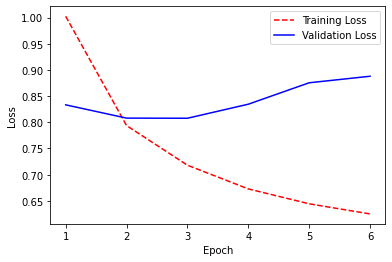

In [30]:
import matplotlib.pyplot as plt

epoch_count = range(1, len(history.history['loss']) + 1)

plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### 정확도 측정

In [31]:
accr = model.evaluate(X_val,y_val)

976/976 [==============================] - 23s 23ms/step - loss: 0.8879 - accuracy: 0.6656


In [32]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.888
  Accuracy: 0.666


In [24]:
X_val[0],y_val[0]

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    1, 9575], dtype=int32),
 array([0., 0., 1., 0., 0.], dtype=float32))

In [25]:
# 예측
sentiment = {0:'부정적', 1:'약간 부정적', 2:'중립적', 3:'약간 긍정적', 4:'긍정적'}
preds = np.argmax(model.predict(X_val[0].reshape(1,-1)))
print('실제값:',sentiment[np.argmax(y_val[0])])
print('예측값:',sentiment[preds])
print('-'*20)
preds = np.argmax(model.predict(X_val[1].reshape(1,-1)))
print('실제값:',sentiment[np.argmax(y_val[1])])
print('예측값:',sentiment[preds])


실제값: 중립적
예측값: 중립적
--------------------
실제값: 중립적
예측값: 중립적
